<a href="https://colab.research.google.com/github/Max280201/TrafficSignCV/blob/main/TrafficSignRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Introduction

Aufgabe: Erkennung von Verkehrsschildern und -zeichen in einem Deep Learning Model erlernen
Verwendung von Deep Learning Frameworks wie Keras, TensorFlow, YOLO o. ä. 

Bereich: Machine & Deep Learning  im autonomen Fahren

As part of the Integrationsseminar our task was to implement Deep Learning Models for detecting and recognizing traffic signs. Therefore we built a combination of two independent models. The first model is for detecting the traffic signs and the second model for recognizing/interpreting the dected traffic signs. For training the Neural Networks (based on Tensorflow) we combined two German Traffic Sign data sets from Kaggle.

# 2 Setup

## 2.1 Imports

In [25]:
from google.colab import drive

import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import glob
from PIL import Image
# imports
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import cv2

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.__version__

'2.9.2'

In [26]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2.2 Configuration

## 2.3 Import Data

* prerequisites: personal access token for kaggle is stored in an kaggle.json file in the root dir or in the drive
* will download the dataset and store it unzipped it in the content dir
* will lead to following directories:
  * GTSDB
    * data_dir: '/content/'
    * train: data_dir+'TrainIJCNN2013/TrainIJCNN2013'
    * test:  data_dir+'TestIJCNN2013/TestIJCNN2013Download'
  * GTSRB
    * data_dir: '/content/'
    * train: data_dir+'Train/'
    * test:  data_dir

In [27]:
! pip install kaggle
! mkdir -p ~/.kaggle/
# for the case, that kaggle.json is stored in the drive
! cp drive/MyDrive/kaggle.json ~/.kaggle/
# for the case, if kaggle.json is stored under the root dir
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cp: cannot stat 'kaggle.json': No such file or directory


### 2.3.1 GTSDB (Object Detection Data)

In [28]:
! kaggle datasets download -d safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb
! unzip -n -q german-traffic-sign-detection-benchmark-gtsdb.zip -d GTSDB

100% 1.61G/1.61G [00:41<00:00, 43.2MB/s]
100% 1.61G/1.61G [00:41<00:00, 42.0MB/s]


### 2.3.2 GTSRB (Image Classification Data)


In [29]:
! kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
! unzip -n -q gtsrb-german-traffic-sign.zip -d GTSRB

 99% 608M/612M [00:15<00:00, 44.3MB/s]
100% 612M/612M [00:15<00:00, 40.4MB/s]


### 2.3.3 Cleanup

In [30]:
! rm kaggle.json
! rm ~/.kaggle/kaggle.json
! rm german-traffic-sign-detection-benchmark-gtsdb.zip
! rm gtsrb-german-traffic-sign.zip

rm: cannot remove 'kaggle.json': No such file or directory


# 3 Data Preparation

## 3.1 Input

In [31]:
data_dir = "/content/"

### 3.1.1 GTSDB

In [32]:
gtsdb_dir = data_dir + 'GTSDB/'
vsplit=.2 
IMAGE_SIZE=[224, 224]
IMAGE_SHAPE=[224,224,3]
train_model=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range = 0.2,
                                   horizontal_flip=True,validation_split=vsplit)
test_model=ImageDataGenerator(rescale=1./255,validation_split=vsplit)
training_data=train_model.flow_from_directory(gtsdb_dir+'TrainIJCNN2013/TrainIJCNN2013',
                                                 target_size=IMAGE_SIZE,batch_size=32,
                                                 class_mode='categorical',subset='training',
                                                 shuffle=True,seed=123)
testing_data=test_model.flow_from_directory(gtsdb_dir+'TrainIJCNN2013/TrainIJCNN2013', 
                                                target_size=IMAGE_SIZE,batch_size = 32,
                                                class_mode='categorical',subset='validation',
                                                shuffle=True,seed=123)
class_dict=training_data.class_indices
classes=list(class_dict.keys())
print('LIST OF CLASSES',classes)
print('CLASS DICTIONARY',class_dict)
number_of_classes=len(classes)
print('Number of classes=',number_of_classes)

Found 702 images belonging to 43 classes.
Found 151 images belonging to 43 classes.
LIST OF CLASSES ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42']
CLASS DICTIONARY {'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5, '06': 6, '07': 7, '08': 8, '09': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42}
Number of classes= 43


### 3.1.2 GTSRB

#### 3.1.2.1 Create setup of the data loading

In [33]:
gtsrb_dir = data_dir + 'GTSRB/'
train_path = gtsrb_dir + 'Train/'
test_path = gtsrb_dir

BATCH_SIZE_CLASSIFICATION = 64
# Resizing the images to 30x30x3
IMG_HEIGHT_CLASSIFICATION = 30
IMG_WIDTH_CLASSIFICATION = 30
CHANNELS = 3

In [34]:
NUM_CATEGORIES = len(os.listdir(train_path))

In [35]:
# Label Overview
class_names = { 0:'Speed limit (20km/h)',
                1:'Speed limit (30km/h)', 
                2:'Speed limit (50km/h)', 
                3:'Speed limit (60km/h)', 
                4:'Speed limit (70km/h)', 
                5:'Speed limit (80km/h)', 
                6:'End of speed limit (80km/h)', 
                7:'Speed limit (100km/h)', 
                8:'Speed limit (120km/h)', 
                9:'No passing', 
                10:'No passing veh over 3.5 tons', 
                11:'Right-of-way at intersection', 
                12:'Priority road', 
                13:'Yield', 
                14:'Stop', 
                15:'No vehicles', 
                16:'Veh > 3.5 tons prohibited', 
                17:'No entry', 
                18:'General caution', 
                19:'Dangerous curve left', 
                20:'Dangerous curve right', 
                21:'Double curve', 
                22:'Bumpy road', 
                23:'Slippery road', 
                24:'Road narrows on the right', 
                25:'Road work', 
                26:'Traffic signals', 
                27:'Pedestrians', 
                28:'Children crossing', 
                29:'Bicycles crossing', 
                30:'Beware of ice/snow',
                31:'Wild animals crossing', 
                32:'End speed + passing limits', 
                33:'Turn right ahead', 
                34:'Turn left ahead', 
                35:'Ahead only', 
                36:'Go straight or right', 
                37:'Go straight or left', 
                38:'Keep right', 
                39:'Keep left', 
                40:'Roundabout mandatory', 
                41:'End of no passing', 
                42:'End no passing veh > 3.5 tons' }

#### 3.1.2.2 Get train, validation and test data

In [36]:
# load data from train directory
image_data = []
image_labels = []
NUM_CATEGORIES = len(os.listdir(train_path))

for i in range(NUM_CATEGORIES):
    path = train_path + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_fromarray = Image.fromarray(imageRGB, 'RGB')
            resize_image = image_fromarray.resize((IMG_WIDTH_CLASSIFICATION, IMG_HEIGHT_CLASSIFICATION))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [37]:
# shuffle train data randomly
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [38]:
# split train dataset to training and validation
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

In [39]:
# load test data
test = pd.read_csv(test_path + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data = []

for img in imgs:
    try:
        image = cv2.imread(test_path + '/' +img)
        imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_fromarray = Image.fromarray(imageRGB, 'RGB')
        resize_image = image_fromarray.resize((IMG_WIDTH_CLASSIFICATION, IMG_HEIGHT_CLASSIFICATION))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
y_test = np.array(labels)

#### 3.1.2.2 Data Exploration

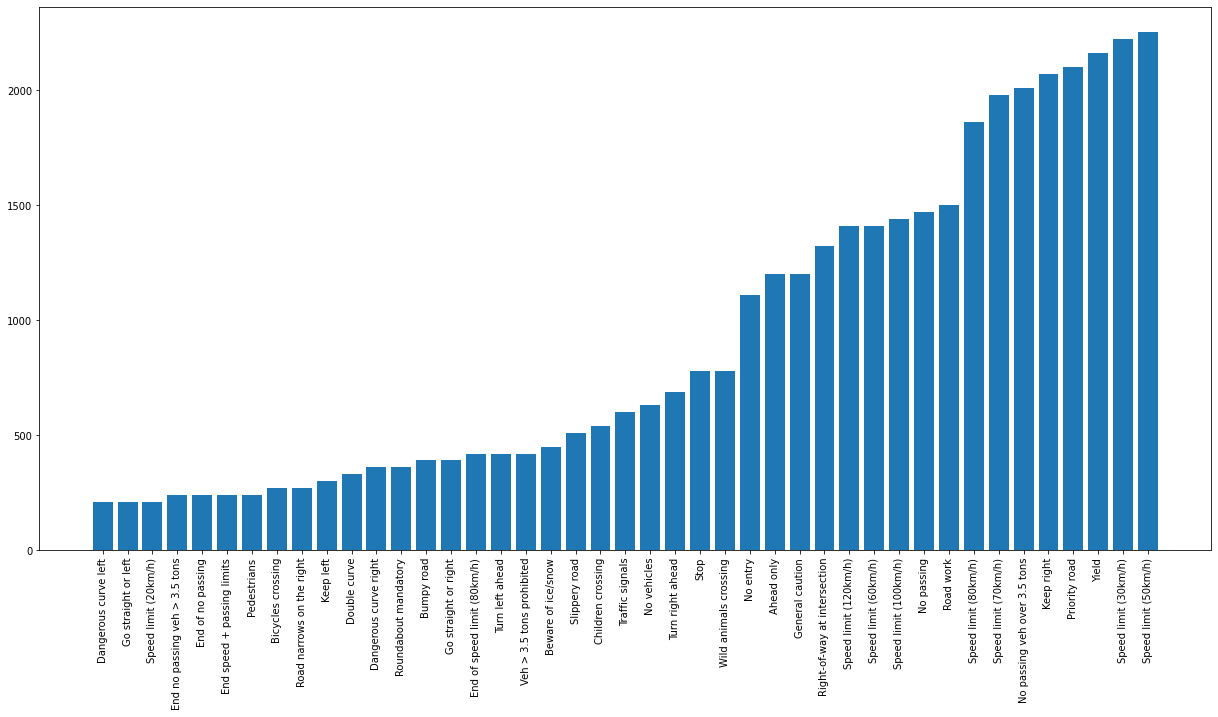

In [40]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(class_names[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

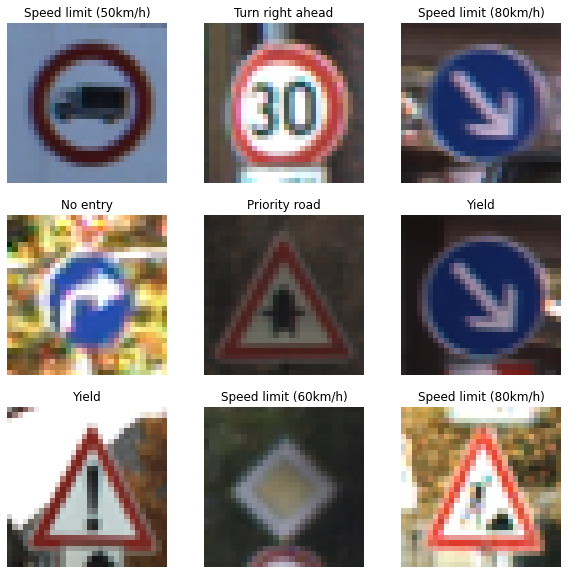

In [41]:
class_numbers = np.unique(image_labels)
plt.figure(figsize=(10, 10))
for counter in range(9):
  ax = plt.subplot(3, 3, counter + 1)
  plt.imshow(X_test[counter].astype("uint8"))
  plt.title(class_names[y_train[counter]])
  plt.axis("off")


# 4 Model training 

In [58]:
num_classes = len(class_names)

model = Sequential([
  layers.InputLayer(input_shape=(IMG_WIDTH_CLASSIFICATION, IMG_HEIGHT_CLASSIFICATION, CHANNELS)),
  # preprocessing layer: will be ignored during testing/ prod
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.1),
  layers.RandomCrop(IMG_WIDTH_CLASSIFICATION - 2, IMG_HEIGHT_CLASSIFICATION - 2),
  layers.RandomTranslation(0.1, 0.1),
  # processing layer
  layers.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(padding='same'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(padding='same'),
  layers.BatchNormalization(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(padding='same'),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_2 (RandomRo  (None, 30, 30, 3)        0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 30, 30, 3)         0         
                                                                 
 random_crop_1 (RandomCrop)  (None, 28, 28, 3)         0         
                                                                 
 random_translation_1 (Rando  (None, 28, 28, 3)        0         
 mTranslation)                                                   
                                                                 
 rescaling_2 (Rescaling)     (None, 28, 28, 3)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 64)       

In [59]:
# train the model
epochs=100

early_stopping = keras.callbacks.EarlyStopping(patience=10,
                                               verbose=2,
                                               restore_best_weights=True)
    
history = model.fit(
  X_train, y_train, 
  validation_data=(X_val, y_val),
  epochs=epochs,
  callbacks=early_stopping
)

Epoch 1/100


858/858 [==============================] - 102s 116ms/step - loss: 2.2884 - accuracy: 0.3179 - val_loss: 1.3958 - val_accuracy: 0.5437
Epoch 2/100
858/858 [==============================] - 96s 112ms/step - loss: 0.9637 - accuracy: 0.6654 - val_loss: 0.5971 - val_accuracy: 0.7903
Epoch 3/100
858/858 [==============================] - 96s 112ms/step - loss: 0.5014 - accuracy: 0.8324 - val_loss: 0.2453 - val_accuracy: 0.9170
Epoch 4/100
858/858 [==============================] - 96s 111ms/step - loss: 0.3054 - accuracy: 0.8987 - val_loss: 0.2386 - val_accuracy: 0.9240
Epoch 5/100
858/858 [==============================] - 93s 108ms/step - loss: 0.2214 - accuracy: 0.9273 - val_loss: 0.2440 - val_accuracy: 0.9313
Epoch 6/100
858/858 [==============================] - 99s 116ms/step - loss: 0.1718 - accuracy: 0.9450 - val_loss: 0.1505 - val_accuracy: 0.9488
Epoch 7/100
858/858 [==============================] - 92s 108ms/step - loss: 0.1611 - accuracy: 0.9499 - val_loss: 0.1182 - val_accura

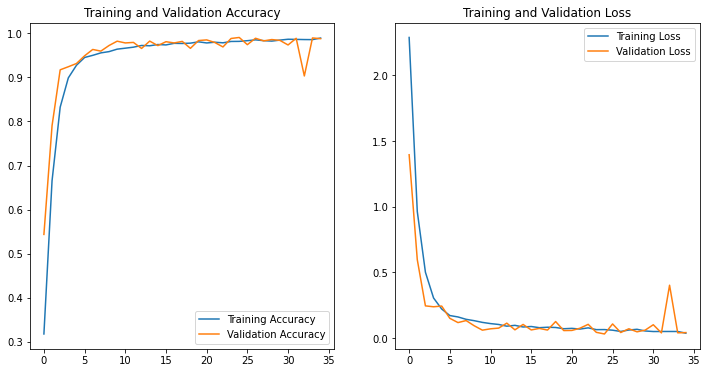

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [61]:
model.evaluate(X_test, y_test)

395/395 [==============================] - 2s 5ms/step - loss: 0.2934 - accuracy: 0.9460


[0.2934105694293976, 0.9460015892982483]

In [62]:
train_ds = (X_train, y_train)
val_ds = (X_val, y_val)
test_ds = (X_test, y_test)

In [63]:
# save model
!mkdir -p drive/MyDrive/checkpoints
model.save_weights('drive/MyDrive/checkpoints/vgg16_model_acc_99_additional_pp_layers_weights')
model.save('drive/MyDrive/checkpoints/vgg16_model_acc_99_additional_pp_layers_model')

# 5 Evaluation

In [64]:
# X_test, y_test = [images for images, labels in val_ds], [labels for images, labels in val_ds]
# X_train, y_train = [images for images, labels in train_ds], [labels for images, labels in train_ds]
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
wrong_predicted_images = np.array([])
for i in range(len(y_test)):
  if y_test[i] != y_pred_classes[i]:
     if len(wrong_predicted_images)!=0:
       wrong_predicted_images = np.append(wrong_predicted_images, X_test[i].reshape((-1, 30, 30, 3)), axis=0)
       wrong_predicted_ylabel = np.append(wrong_predicted_ylabel, y_pred_classes[i])
     else:
       wrong_predicted_images = X_test[i].reshape((-1, 30, 30, 3))
       wrong_predicted_ylabel = y_pred_classes[i]

395/395 [==============================] - 2s 4ms/step


In [65]:
y_pred_classes.shape, y_test.shape, y_train.shape, X_train.shape, X_test.shape, wrong_predicted_images.shape, wrong_predicted_ylabel.shape

((12630,),
 (12630,),
 (27446,),
 (27446, 30, 30, 3),
 (12630, 30, 30, 3),
 (682, 30, 30, 3),
 (682,))

In [66]:
a = confusion_matrix(y_test, y_pred_classes)

# fill diagonal
np.fill_diagonal(a, False)

# columns with at least one non-zero
cols = a.any(axis=0)

# rows with at least one non-zero
rows = a.any(axis=1)

# filter columns and rows that have values above one threshold
threshold = 1.5
rows_nb, col_nb = a.shape
rows_above_threshold = [col for col in range(col_nb) \
    if any([a[row][col] >= threshold for row in range(rows_nb)])]
columns_above_threshold = [row for row in range(rows_nb) \
    if any([a[row][col] >= threshold for col in range(col_nb)])]

In [67]:
a = pd.DataFrame(a, index=class_names.values(), columns=class_names.values())
# a.iloc[rows_above_threshold+columns_above_threshold, rows_above_threshold+columns_above_threshold]
a.iloc[columns_above_threshold, rows_above_threshold]

,Speed limit (20km/h),Speed limit (30km/h),Speed limit (50km/h),Speed limit (60km/h),Speed limit (70km/h),Speed limit (80km/h),End of speed limit (80km/h),Speed limit (100km/h),Speed limit (120km/h),No passing,...,Bicycles crossing,Beware of ice/snow,Wild animals crossing,End speed + passing limits,Turn left ahead,Go straight or right,Keep right,Roundabout mandatory,End of no passing,End no passing veh > 3.5 tons
Speed limit (20km/h),0,0,0,0,12,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Speed limit (30km/h),3,0,1,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Speed limit (50km/h),0,6,0,4,3,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
Speed limit (60km/h),0,0,2,0,0,2,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
Speed limit (70km/h),4,9,1,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
Speed limit (80km/h),0,2,25,10,10,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
End of speed limit (80km/h),0,0,0,0,0,1,0,0,0,20,...,0,0,0,1,0,0,0,0,0,0
Speed limit (100km/h),0,0,0,0,0,2,0,0,9,0,...,0,1,0,0,0,0,0,0,0,0
Speed limit (120km/h),0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
No passing veh over 3.5 tons,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


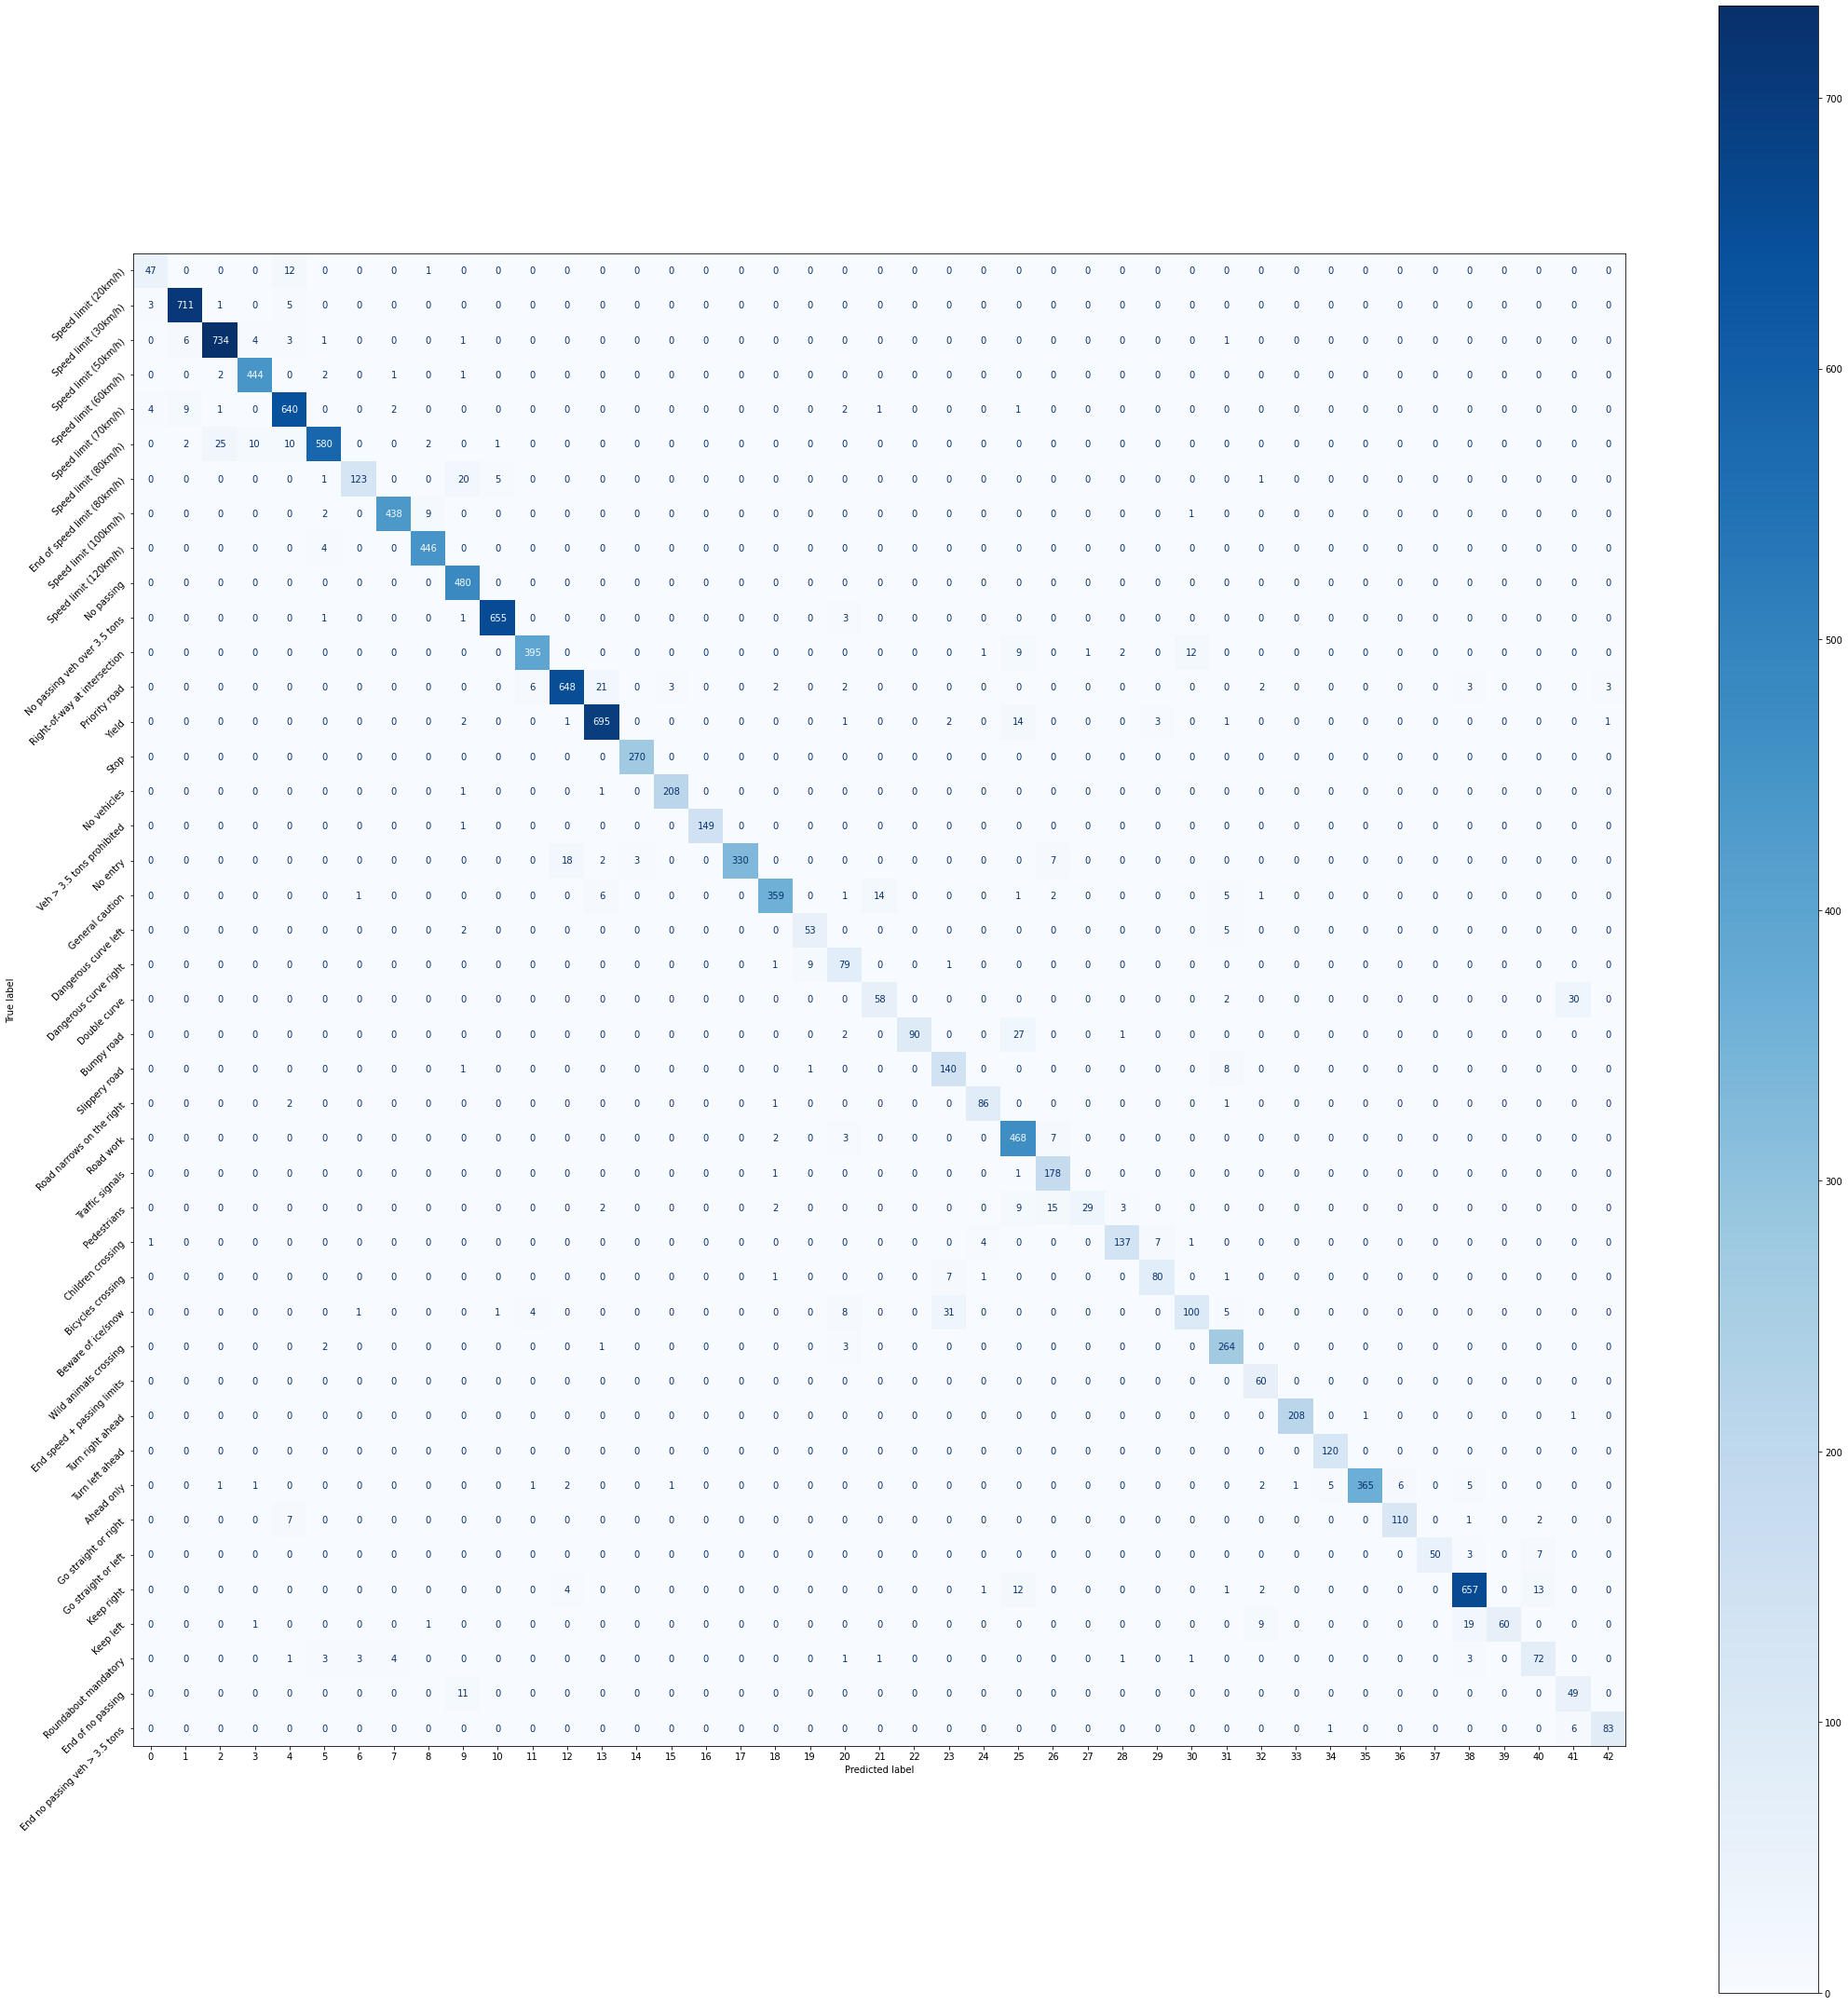

In [68]:
fig, ax = plt.subplots(figsize=(30,30))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_classes, cmap="Blues", ax=ax)
# sns.heatmap(a, cmap="Blues", ax=ax)
ax.set_yticklabels(list(class_names.values()), rotation=45)
#ax.set_xticklabels(list(class_names.values()), rotation=45)
fig.set_tight_layout(True)
plt.show()

In [69]:
from pprint import pprint
pprint(classification_report(y_test, y_pred_classes, target_names=list(class_names.values()), \
                             labels=list(class_names.keys())))

('                               precision    recall  f1-score   support\n'
 '\n'
 '         Speed limit (20km/h)       0.85      0.78      0.82        60\n'
 '         Speed limit (30km/h)       0.98      0.99      0.98       720\n'
 '         Speed limit (50km/h)       0.96      0.98      0.97       750\n'
 '         Speed limit (60km/h)       0.97      0.99      0.98       450\n'
 '         Speed limit (70km/h)       0.94      0.97      0.96       660\n'
 '         Speed limit (80km/h)       0.97      0.92      0.95       630\n'
 '  End of speed limit (80km/h)       0.96      0.82      0.88       150\n'
 '        Speed limit (100km/h)       0.98      0.97      0.98       450\n'
 '        Speed limit (120km/h)       0.97      0.99      0.98       450\n'
 '                   No passing       0.92      1.00      0.96       480\n'
 ' No passing veh over 3.5 tons       0.99      0.99      0.99       660\n'
 ' Right-of-way at intersection       0.97      0.94      0.96       420\n'
 '    

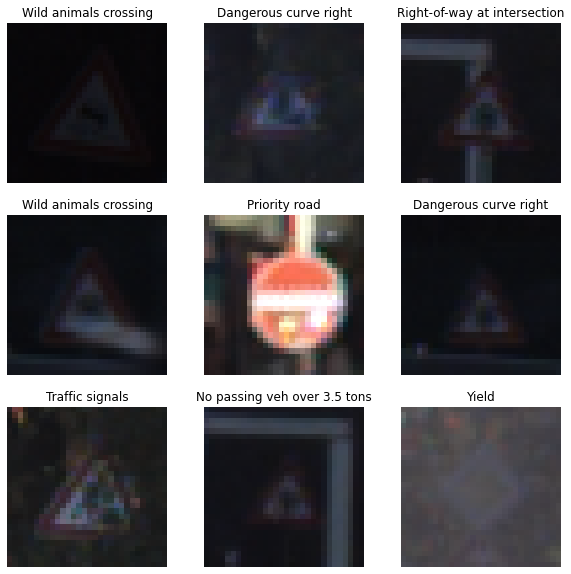

In [70]:
plt.figure(figsize=(10, 10))
plt.title("Wrong predicted traffic signs")
for i in range(min(len(wrong_predicted_images), 9)):
    ax = plt.subplot((min(len(wrong_predicted_images), 9)-1)//3+1, 3, i + 1)
    plt.imshow(wrong_predicted_images[i].astype("uint8"))
    plt.title(class_names[wrong_predicted_ylabel[i]])
    plt.axis("off")

# 6 Compare Models 

In [71]:
#@title select models for evaluation
evaluate_basic_vgg16_model = True #@param {type:"boolean"}
evaluate_vgg16_model_with_additional_preprocessing_layer = True #@param {type:"boolean"}

file_path_basic_vgg16_model = "drive/MyDrive/checkpoints/vgg16_model_acc_99_model" #@param {type:"string"}
file_path_vgg16_model_with_additional_preprocessing_layer = "drive/MyDrive/checkpoints/vgg16_model_acc_99_additional_pp_layers_model" #@param {type:"string"}

In [72]:
# load models
if evaluate_basic_vgg16_model:
  model_basic_vgg16 = load_model(file_path_basic_vgg16_model)
  score_mapp = model_basic_vgg16.evaluate(X_test, y_test)

395/395 [==============================] - 2s 4ms/step - loss: 0.2916 - accuracy: 0.9599


In [73]:
if evaluate_vgg16_model_with_additional_preprocessing_layer:
  model_additional_pp_layers = load_model(file_path_vgg16_model_with_additional_preprocessing_layer)
  score_mapp = model_additional_pp_layers.evaluate(X_test, y_test)

395/395 [==============================] - 2s 5ms/step - loss: 0.2934 - accuracy: 0.9460
